# Simulations

In [1]:
import sys
sys.path.append("C:\\Users\\User\\Vrije Universiteit Brussel\\Mehdi Feizpour - Halewijn's Thesis Project\\master thesis\\other")
sys.path.append("C:\\Users\\mfeizpou\\OneDrive - Vrije Universiteit Brussel\\Halewijn's Thesis Project\\master thesis\other")

import importlib
import color_maps as cm
import my_functions as mf
import filepaths as fp
import variables
import figure_label_names as fln
from matplotlib.ticker import ScalarFormatter, FuncFormatter

mf = importlib.reload(mf)
fp = importlib.reload(fp)
cm = importlib.reload(cm)

import pandas as pd
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import matplotlib.animation as animation
from scipy import interpolate
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit



from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y
import pickle
from sklearn.metrics import accuracy_score, f1_score
from sklearn.dummy import DummyClassifier



In [2]:
def reload_libraries(): 
    import importlib
    import my_functions as mf
    import filepaths as fp
    import color_maps as cm
    import variables
    import figure_label_names as fln
    mf = importlib.reload(mf)
    fp = importlib.reload(fp)
    cm = importlib.reload(cm)
    variables = importlib.reload(variables)
    fln = importlib.reload(fln)
    print('done')

def get_gaussian_noise_intensity(melt_df, mean, std_dev): 
    melt_df_copy = melt_df.copy()
    # Calculate the number of datapoints
    num_datapoints = melt_df_copy.shape[0]
    # Generate Gaussian noise
    noise = np.random.normal(mean, std_dev, num_datapoints)
    melt_df_copy.loc[:, 'intensity_noise'] = melt_df_copy.loc[:, 'intensity'] + noise
    return melt_df_copy


def get_accuracy_from_model(noise_vector_df): 
    #get the new data from the vector df
    X, y = mf.get_X_y_from_vector_df(noise_vector_df)
    # Perform LDA transformation
    lda_transformed_data = lda_pipeline.transform(X.values)
    # Perform GMM prediction on the transformed data
    gmm_predictions = gmm_pipeline.predict(pd.DataFrame(lda_transformed_data))
    # Create a DataFrame to associate original labels with cluster assignments
    results_df = pd.DataFrame({'true_class': y, 'gmm_predicted_class': gmm_predictions})
    #get the map
    map = pd.read_csv(fp.intermediate_data_filepath + '/' + 'gmm_map.csv')
    #now apply this majority map
    class_results_df = mf.convert_GMM_to_class_labels(results_df, map)
    #calculate the accuracy and f1
    accuracy, f1 = mf.get_accuracy_and_f1(class_results_df.loc[:, 'true_gmm_class'], class_results_df.loc[:, 'gmm_predicted_class'])
    return accuracy, f1

def train_model_and_get_results(vector_df, n_components):
    X, y = mf.get_X_y_from_vector_df(vector_df)
    # Splitting the data into training and testing sets with a 70-30 split ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    
    #make the pipeline
    lda_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('lda', LinearDiscriminantAnalysis())
    ])
    
    #GMM pipeline
    gmm_pipeline = Pipeline([
        ('gmm', GaussianMixture(n_components=n_components))  # Adjust n_components for GMM
    ])
    
    # #fit_transform the lda_df
    # train_lda = pd.DataFrame(lda_pipeline.fit_transform(X_train, y_train))
    # #fit_transform the lda_df
    # test_lda = pd.DataFrame(lda_pipeline.transform(X_test))
    
    #make the train_lda_df
    train_lda_df = pd.DataFrame(lda_pipeline.fit_transform(X_train, y_train))
    #predict the train labels
    train_predictions = gmm_pipeline.fit_predict(train_lda_df)
    #make the test_lda_df
    test_lda_df = pd.DataFrame(lda_pipeline.transform(X_test))
    #make the test predictions
    test_predictions = gmm_pipeline.predict(test_lda_df)
    # Create a DataFrame to associate original labels with cluster assignments
    train_df = pd.DataFrame({'true_class': y_train, 'gmm_predicted_class': train_predictions})
    #create the test df
    test_df = pd.DataFrame({'true_class': y_test, 'gmm_predicted_class': test_predictions})

    #get the map based on majority voting
    map = train_df.groupby('true_class').apply(mf.majority_vote).reset_index().rename({
        'true_class': 'gmm_class',
        0: 'gmm_class_numerical'}, axis = 1)
    
    #now apply this majority map
    class_train_df = mf.convert_GMM_to_class_labels(train_df, map)
    class_test_df = mf.convert_GMM_to_class_labels(test_df, map)

    return class_train_df, class_test_df


def get_interpolated_df(results_df, window_length): 
    # Filter the DataFrame based on the specified window_length
    df = results_df[results_df.loc[:, 'window_length'] == window_length]
    # Extract center wavenumbers and corresponding accuracies
    wavenumbers = df.loc[:, 'center_wavenumber']
    accuracies = df.loc[:, 'test_accuracy']
    # Determine the minimum and maximum wavenumbers from the filtered data
    min_wavenumber = wavenumbers.min()
    max_wavenumber = wavenumbers.max()
    
    # Generate uniformly spaced wavenumbers within the range
    interpolated_wavenumbers = np.arange(min_wavenumber, max_wavenumber + 1, 1)
    # Create a linear interpolation function using scipy.interpolate.interp1d
    interp_func = interpolate.interp1d(wavenumbers, accuracies, kind='linear')
    # Perform interpolation to calculate accuracies at each original wavenumber
    interpolated_accuracies = interp_func(interpolated_wavenumbers)
    
    # Create a new DataFrame to store interpolated data
    interpolated_df = pd.DataFrame({
        'window_length': [window_length]*len(interpolated_wavenumbers),  # Original window lengths
        'center_wavenumber': interpolated_wavenumbers,             # Original wavenumbers
        'test_accuracy': interpolated_accuracies      # Interpolated accuracies
    })
    return interpolated_df


def get_equidistant_undersampling(melt_df, desired_num_points):
    
    min_wavenumber = melt_df.loc[:, 'wavenumber'].min()
    max_wavenumber = melt_df.loc[:, 'wavenumber'].max()
    new_wavenumbers = np.linspace(min_wavenumber, max_wavenumber, desired_num_points)
    equidistand_undersampling_df = melt_df.sort_values('wavenumber').groupby('measurement_index').apply(resample_and_interpolate, desired_num_points = desired_num_points, new_wavenumbers = new_wavenumbers).reset_index().drop('level_1', axis = 1)
    return equidistand_undersampling_df


def resample_and_interpolate(group, desired_num_points, new_wavenumbers):
    class_array = [list(group['Class'])[0]]*desired_num_points
    # Interpolate intensity values for the new wavenumbers
    new_intensity_values = np.interp(new_wavenumbers, group['wavenumber'], group['intensity'])
    # Create a new DataFrame with interpolated values for the group
    new_group_df = pd.DataFrame({'Class': class_array,
                                'wavenumber': new_wavenumbers,
                                 'intensity': new_intensity_values})
    return new_group_df

def get_accuracy_of_equidistant_undersampled_model(melt_df, desired_num_points): 
    #get the undersampled dataframe
    undersampled_melt_df = get_equidistant_undersampling(melt_df, desired_num_points)
    #get the vecvector_df
    undersampled_vector_df = mf.get_vector_df(undersampled_melt_df, 'intensity')
    #train the model and get the result
    class_train_df, class_test_df = train_model_and_get_results(undersampled_vector_df, n_components=3)
    #calculate accuracy and f1 score
    test_accuracy, f1 = mf.get_accuracy_and_f1(class_test_df.loc[:, 'true_gmm_class'], class_test_df.loc[:, 'gmm_predicted_class'])
    train_accuracy, f1 = mf.get_accuracy_and_f1(class_train_df.loc[:, 'true_gmm_class'], class_train_df.loc[:, 'gmm_predicted_class'])
    return train_accuracy, test_accuracy

## Import data

In [3]:
reload_libraries()
data_path = fp.second_semester_data_path
#read in the data
vector_df = pd.read_csv(data_path + '/' + 'vector_df.csv')
vector_df.iloc[:, 2:] = vector_df.iloc[:, 2:].astype('float64')
#get the melted df
melt_df = mf.get_melt_df(vector_df)

done


## Noise simulations

### Gaussian noise

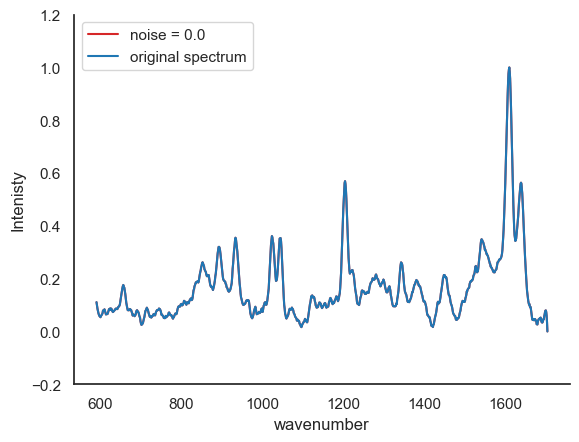

In [58]:
#this is the original spectrum 
original_spectrum_df = mf.get_measurement_spectrum(0,melt_df)

frames = 50
lower_std_value = 0
upper_std_value = 0.2

# Create a figure and axis
fig, ax = plt.subplots()
sns.set(style="white")
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Initialize scatter plot with an empty plot
scatter = sns.scatterplot(ax=ax)

def update_noise(frame): 
    # Clear previous plot
    ax.clear()
    # Update data for the plot (example: sinusoidal wave animation)
    std_dev_array = np.linspace(lower_std_value, upper_std_value, frames)
    #get the standard deviation for this frame
    std_dev = std_dev_array[frame]
    #now generate the noise for the gaussian data
    noisy_data = get_gaussian_noise_intensity(mf.get_measurement_spectrum(0, melt_df), 0, std_dev)
    #now plot the scatterplot
    sns.lineplot(data =noisy_data, x ='wavenumber', y = 'intensity_noise', color = 'tab:red',  label = 'noise = ' + str(std_dev))
    #plot the original spectrum first
    sns.lineplot(data = original_spectrum_df, x ='wavenumber', y = 'intensity', label = 'original spectrum', alpha = 1, color = 'tab:blue')
    plt.ylim(-0.2,1.2)
    ax.set_xlabel('wavenumber')
    ax.set_ylabel('Intenisty')

# Create the animation
ani = animation.FuncAnimation(fig, update_noise, frames=frames, interval=100)
ani.save(fp.video_filepath + '/' + 'noise_animation.mp4', writer='ffmpeg', fps=10)

#### Original model on the noise

In [11]:
#this code takes 5 min
answer = input('Do you want to run this? This might take a while')
mean = 0
if answer == 'y': 
    filename = input('wwat is the filenmae')
    #num_observations = 5
    num_observations = 5
    #import the model
    # Load the LDA model
    with open(fp.second_semester_model_path + '/' + 'lda_pipeline.pkl', 'rb') as lda_file:
        lda_pipeline = pickle.load(lda_file)
    
    # Load the GMM model
    with open(fp.second_semester_model_path + '/' + 'gmm_pipeline.pkl', 'rb') as gmm_file:
        gmm_pipeline = pickle.load(gmm_file)

    std_dev_array = np.arange(0, 0.2, 0.0025)
    accuracy_array = []
    current_observation_array = []
    current_std_array = []
    
    for ii in range(len(std_dev_array)):
        std_dev = std_dev_array[ii]
        percentage = int((ii+1)/len(std_dev_array)*100)
        print(str(percentage) + ' complete')
        for num_observation in range(num_observations):
            #the dataframe with the added noise
            noise_melt_df = get_gaussian_noise_intensity(melt_df,mean, std_dev)
            #convert the melt df to a dataframe
            noise_vector_df = mf.get_vector_df(noise_melt_df, 'intensity_noise')
            accuracy, f1 = get_accuracy_from_model(noise_vector_df)
            accuracy_array += [accuracy]
            current_std_array += [std_dev]
            current_observation_array += [num_observation]
    
    noise_performance_results = pd.DataFrame({'standard_deviation': current_std_array,
                                          'accuracy': accuracy_array, 
                                         'current_observation': current_observation_array})
    noise_performance_results.to_csv(fp.second_semester_simulation_data_path + '/'  + filename + '.csv', index = False)


Do you want to run this? This might take a while y
wwat is the filenmae Accuracy_vs_std_original_model


1 complete
2 complete
3 complete
5 complete
6 complete
7 complete
8 complete
10 complete
11 complete
12 complete
13 complete
15 complete
16 complete
17 complete
18 complete
20 complete
21 complete
22 complete
23 complete
25 complete
26 complete
27 complete
28 complete
30 complete
31 complete
32 complete
33 complete
35 complete
36 complete
37 complete
38 complete
40 complete
41 complete
42 complete
43 complete
45 complete
46 complete
47 complete
48 complete
50 complete
51 complete
52 complete
53 complete
55 complete
56 complete
57 complete
58 complete
60 complete
61 complete
62 complete
63 complete
65 complete
66 complete
67 complete
68 complete
70 complete
71 complete
72 complete
73 complete
75 complete
76 complete
77 complete
78 complete
80 complete
81 complete
82 complete
83 complete
85 complete
86 complete
87 complete
88 complete
90 complete
91 complete
92 complete
93 complete
95 complete
96 complete
97 complete
98 complete
100 complete


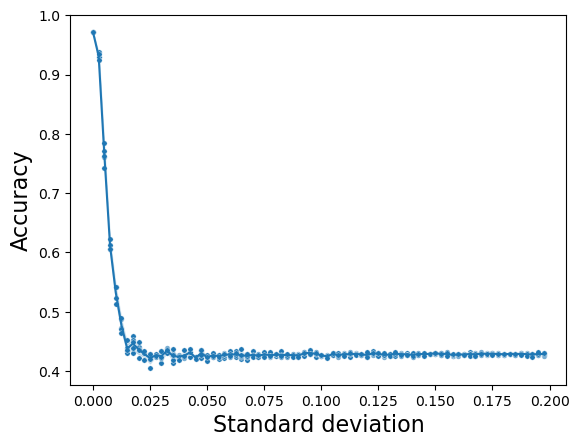

In [12]:

sns.lineplot(noise_performance_results, x = 'standard_deviation', y = 'accuracy')
sns.scatterplot(noise_performance_results, x = 'standard_deviation', y = 'accuracy', s = variables.scatterplot_size)
plt.xlabel('Standard deviation', fontsize = variables.x_y_label_fontsize)
plt.ylabel('Accuracy',fontsize = variables.x_y_label_fontsize)
# plt.legend(fontsize = variables.fontsize)
plt.savefig(fp.figure_filepath + '/' + 'Accuracy_vs_std_original_model.png', bbox_inches = 'tight')
plt.show()

#### train model on the higher noise

In [15]:
#this code takes 10 min
reload_libraries()
import warnings
warnings.filterwarnings("ignore", message=".*KMeans is known to have a memory leak on Windows with MKL.*")
answer = input('Do you want to run this? This might take a while')
if answer == 'y': 
    filename = input('what is the filename')
    std_dev_array = np.arange(0, 0.2, 0.0025)
    train_accuracy_array = []
    test_accuracy_array = []
    dummy_accuracy_array = []
    current_observation_array = []
    current_std_array = []
    mean = 0
    num_observations = 5
    #num_observations = 2
    for ii in range(len(std_dev_array)):
        std_dev = std_dev_array[ii]
        print(str(int((ii+1)/len(std_dev_array)*100)) + ' complete')
    # for std_dev in std_dev_array:
    #     print(std_dev)
        for observation_num in range(num_observations):
            #get the noise onto the data
            noise_melt_df = get_gaussian_noise_intensity(melt_df,mean, std_dev)
            #make it into a vector
            noise_vector_df = mf.get_vector_df(noise_melt_df, 'intensity_noise')
            #get the results
            class_train_df, class_test_df = train_model_and_get_results(noise_vector_df, n_components=3)
            #get the train and test accuracy
            train_accuracy, f1 = mf.get_accuracy_and_f1(class_train_df.loc[:, 'true_gmm_class'], class_train_df.loc[:, 'gmm_predicted_class'])
            test_accuracy, f1 = mf.get_accuracy_and_f1(class_test_df.loc[:, 'true_gmm_class'], class_test_df.loc[:, 'gmm_predicted_class'])
            train_accuracy_array += [train_accuracy]
            test_accuracy_array += [test_accuracy]
            dummy_accuracy_array += [mf.get_dummy_accuracy(noise_vector_df)]
            current_std_array += [std_dev]
            current_observation_array += [observation_num]

    #save the results
    noise_performance_adjusted_model_results_df = pd.DataFrame({'standard_deviation': current_std_array,
                                             'observation_num': current_observation_array,
                                            'train_accuracy': train_accuracy_array,
                                             'test_accuracy': test_accuracy_array,
                                            'dummy_accuracy': dummy_accuracy_array})
    
    noise_performance_adjusted_model_results_df = pd.melt(noise_performance_adjusted_model_results_df, id_vars=['standard_deviation', 'observation_num'], var_name='train_or_test', value_name='score')
    #save the file
    # noise_performance_adjusted_model_results_df.to_csv(fp.simulation_data_filepath + '/' + filename + '.csv', index = False)
    mf.save_dataframe_without_overwrite(noise_performance_adjusted_model_results_df, fp.second_semester_simulation_data_path, filename, False)
    print('done')

done


Do you want to run this? This might take a while y
what is the filename noise_performance_adjusted_model_results


1 complete
2 complete
3 complete
5 complete
6 complete
7 complete
8 complete
10 complete
11 complete
12 complete
13 complete
15 complete
16 complete
17 complete
18 complete
20 complete
21 complete
22 complete
23 complete
25 complete
26 complete
27 complete
28 complete
30 complete
31 complete
32 complete
33 complete
35 complete
36 complete
37 complete
38 complete
40 complete
41 complete
42 complete
43 complete
45 complete
46 complete
47 complete
48 complete
50 complete
51 complete
52 complete
53 complete
55 complete
56 complete
57 complete
58 complete
60 complete
61 complete
62 complete
63 complete
65 complete
66 complete
67 complete
68 complete
70 complete
71 complete
72 complete
73 complete
75 complete
76 complete
77 complete
78 complete
80 complete
81 complete
82 complete
83 complete
85 complete
86 complete
87 complete
88 complete
90 complete
91 complete
92 complete
93 complete
95 complete
96 complete
97 complete
98 complete
100 complete
done


#### calculate SNR

In [16]:
reload_libraries()
mean = 0
std = 2
def get_SNR(melt_df, std): 
    """
    Calculate the Signal-to-Noise Ratio (SNR) for a given melted DataFrame.

    Parameters:
    - melt_df (pd.DataFrame): Melted DataFrame containing columns 'wavenumber' and 'intensity'.
    - std (float): Standard deviation parameter for generating Gaussian noise.
    """
    min_intensity = melt_df.loc[:, 'intensity'].min()
    baseline_corrected_melt_df = melt_df.copy()
    baseline_corrected_melt_df.loc[:, 'intensity'] = melt_df.loc[:, 'intensity'] - min_intensity
    
    noise_melt_df = mf.get_gaussian_noise_intensity(baseline_corrected_melt_df, mean, std)
    std = noise_melt_df.groupby(['wavenumber'], as_index = False)['intensity_noise'].std()
    signal = mf.get_mean_spectrum(baseline_corrected_melt_df)
    SNR = signal.loc[:, 'intensity']/std.loc[:, 'intensity_noise']
    
    return SNR.mean()

# Extract unique standard deviations from a DataFrame
std_array = noise_performance_adjusted_model_results_df.loc[:, 'standard_deviation'].unique()

# Calculate SNR for each unique standard deviation
SNR_array = []
for std in std_array:
    SNR_array += [get_SNR(melt_df, std)]

# Create a DataFrame mapping standard deviations to SNR values
std_snr_map = pd.DataFrame({'standard_deviation': std_array,
                             'Signal-to-Noise Ratio': SNR_array})

done


#### display the results

In [17]:
#read the dataframe for the noise adjusted model
noise_performance_adjusted_model_results_df = pd.read_csv(fp.second_semester_simulation_data_path + '/' + 'noise_performance_adjusted_model_results.csv')
noise_performance_adjusted_model_results_df =  noise_performance_adjusted_model_results_df.replace({'train_accuracy': 'noise-trained model: train accuracy',
                                                                                                    'test_accuracy': 'noise-trained model: test accuracy',
                                                                                                    'dummy_accuracy': 'dummy accuracy'
                                                                                                   })


#read the dataframe for model trained without noise                                                 
noise_performance_results_df = pd.read_csv(fp.second_semester_simulation_data_path + '/' + 'Accuracy_vs_std_original_model.csv')
noise_performance_results_df.loc[:, 'train_or_test'] = ['noise-free model']*noise_performance_results_df.shape[0]
noise_performance_results_df = noise_performance_results_df.rename(columns={'accuracy': 'score'})
noise_performance_results_df = noise_performance_results_df.rename({'current_observation': 'observation_num'}, axis =1)

#concatenate the two dataframes
noise_performance_results_df_reordered = noise_performance_results_df[noise_performance_adjusted_model_results_df.columns]
#concatenate them
concat_df = pd.concat([noise_performance_results_df_reordered, noise_performance_adjusted_model_results_df])
#convert to snr
# Extract unique standard deviations from a DataFrame
std_array = concat_df.loc[:, 'standard_deviation'].unique()
# Calculate SNR for each unique standard deviation
SNR_array = []
for std in std_array:
    SNR_array += [get_SNR(melt_df, std)]
# Create a DataFrame mapping standard deviations to SNR values
std_snr_map = pd.DataFrame({'standard_deviation': std_array,
                             'Signal-to-Noise Ratio': SNR_array})
#convert to snr
concat_df = pd.merge(concat_df, std_snr_map,how = 'left')
#do the snr in the logscale
concat_df.loc[:, 'log Signal-to-Noise Ratio'] = np.log10(concat_df.loc[:, 'Signal-to-Noise Ratio'] )

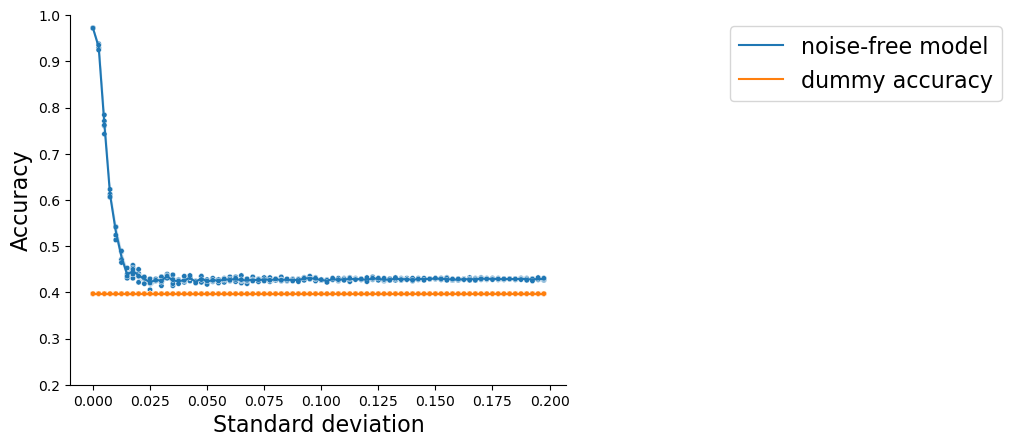

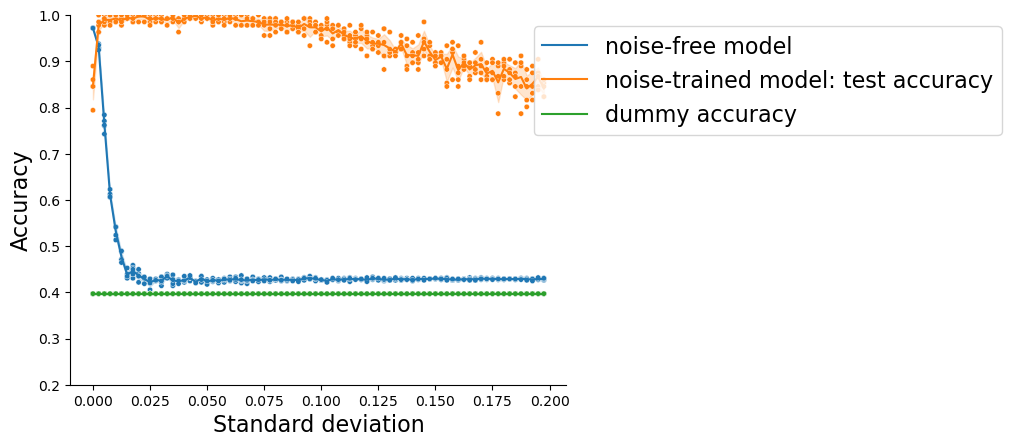

In [18]:
#filter for the first figure
concat_df.loc[:, 'train_or_test'].unique()
filt_fig1 = (concat_df.loc[:, 'train_or_test'] == 'dummy accuracy') | (concat_df.loc[:, 'train_or_test'] == 'noise-free model')

#filter for the second figure
concat_df.loc[:, 'train_or_test'].unique()
filt_fig2 = (concat_df.loc[:, 'train_or_test'] == 'dummy accuracy') | (concat_df.loc[:, 'train_or_test'] == 'noise-free model') | (concat_df.loc[:, 'train_or_test'] == 'noise-trained model: test accuracy')

#first plot the first figure
#start the plotting
lineplot = sns.lineplot(concat_df[filt_fig1], x= 'standard_deviation', y = 'score', hue= 'train_or_test')
lineplot.legend_.set_title('')
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1), fontsize = variables.x_y_label_fontsize)

sns.scatterplot(concat_df[filt_fig1], x= 'standard_deviation', y = 'score', hue= 'train_or_test', legend = False,s = variables.scatterplot_size)
# Hide the right and upper spines (axes)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.ylim(0.2, 1)
plt.xlabel('Standard deviation', fontsize = variables.x_y_label_fontsize)
plt.ylabel('Accuracy', fontsize = variables.x_y_label_fontsize)
plt.savefig(fp.figure_filepath + '/' + 'Standar_deviation_vs_accuracy_for_noise.png', bbox_inches = 'tight')
plt.show()

#plot the second figure
lineplot = sns.lineplot(concat_df[filt_fig2], x= 'standard_deviation', y = 'score', hue= 'train_or_test')
lineplot.legend_.set_title('')
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1), fontsize = variables.x_y_label_fontsize)

sns.scatterplot(concat_df[filt_fig2], x= 'standard_deviation', y = 'score', hue= 'train_or_test', legend = False,s = variables.scatterplot_size)
# Hide the right and upper spines (axes)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.ylim(0.2, 1)
plt.xlabel('Standard deviation', fontsize = variables.x_y_label_fontsize)
plt.ylabel('Accuracy', fontsize = variables.x_y_label_fontsize)
plt.savefig(fp.figure_filepath + '/' + 'Standar_deviation_vs_accuracy_for_noise.png', bbox_inches = 'tight')
plt.show()

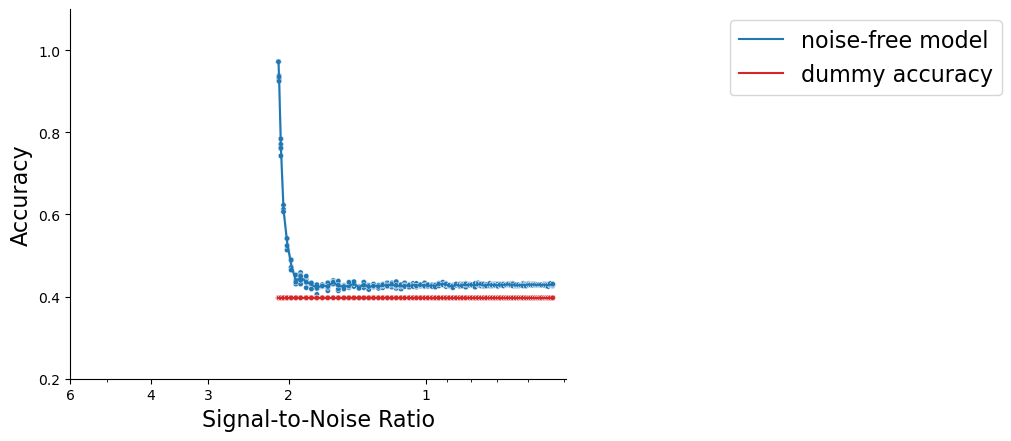

In [19]:
concat_df_fig_1 = concat_df[filt_fig1]

hue_colors = {'dummy accuracy': 'tab:red', 'noise-free model': 'tab:blue'}

lineplot = sns.lineplot(concat_df_fig_1, x= 'Signal-to-Noise Ratio', y = 'score', hue= 'train_or_test', palette=hue_colors)
lineplot.legend_.set_title('')
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1), fontsize = variables.x_y_label_fontsize)
#convert to snr
concat_df_fig_1 = pd.merge(concat_df_fig_1, std_snr_map,how = 'left')


scatterplot = sns.scatterplot(concat_df_fig_1, x= 'Signal-to-Noise Ratio', y = 'score', hue= 'train_or_test',palette=hue_colors, legend = False,s = variables.scatterplot_size)
scatterplot.set(xscale = 'log')
#Hide the right and upper spines (axes)
ax = plt.gca()
ax.invert_xaxis()
# Choose specific values for tick marks on the x-axis
custom_ticks = [6, 4, 3, 2 ,1]
scatterplot.set(xticks=custom_ticks)

# Use FuncFormatter to format x-axis tick labels
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# Choose specific values for tick marks on the x-axis
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.ylim(0.2, 1.1)
plt.xlabel('Signal-to-Noise Ratio', fontsize = variables.x_y_label_fontsize)
plt.ylabel('Accuracy', fontsize = variables.x_y_label_fontsize)
plt.savefig(fp.figure_filepath + '/' + 'accuracy_vs_std_noise_free.png', bbox_inches = 'tight')
plt.show()

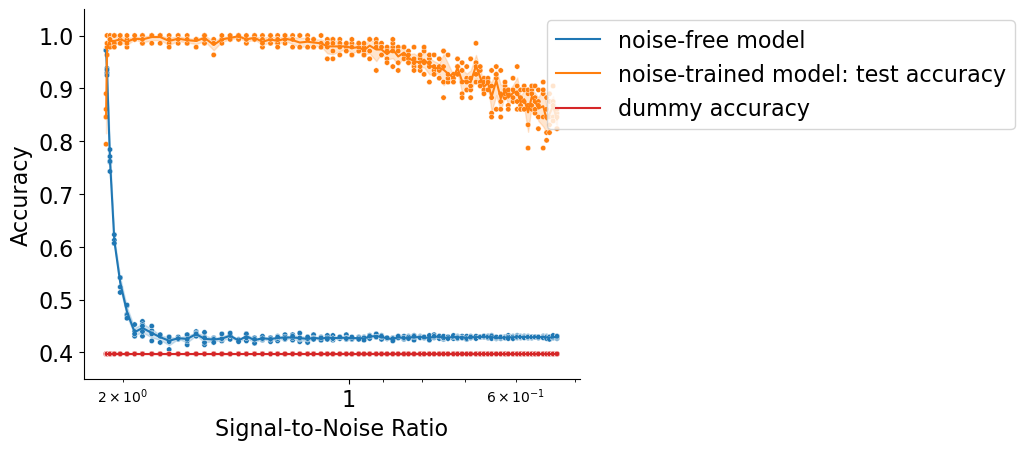

In [25]:
concat_df_fig_2 = concat_df[filt_fig2]

hue_colors = {'dummy accuracy': 'tab:red', 'noise-free model': 'tab:blue', 'noise-trained model: test accuracy': 'tab:orange'}

lineplot = sns.lineplot(concat_df_fig_2, x= 'Signal-to-Noise Ratio', y = 'score', hue= 'train_or_test', palette=hue_colors)
lineplot.legend_.set_title('')
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1), fontsize = variables.x_y_label_fontsize)
#convert to snr
concat_df_fig_2 = pd.merge(concat_df_fig_2, std_snr_map,how = 'left')


scatterplot = sns.scatterplot(concat_df_fig_2, x= 'Signal-to-Noise Ratio', y = 'score', hue= 'train_or_test',palette=hue_colors, legend = False,s = variables.scatterplot_size)
scatterplot.set(xscale = 'log')
#Hide the right and upper spines (axes)
ax = plt.gca()
ax.invert_xaxis()
# Choose specific values for tick marks on the x-axis
# custom_ticks = [3, 2 ,1]
# scatterplot.set(xticks=custom_ticks)

# Use FuncFormatter to format x-axis tick labels
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# Choose specific values for tick marks on the x-axis
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xticks(fontsize = variables.tick_fontsize)
plt.yticks(fontsize = variables.tick_fontsize)
plt.ylim(0.35, 1.05)
plt.xlabel('Signal-to-Noise Ratio', fontsize = variables.x_y_label_fontsize)
plt.ylabel('Accuracy', fontsize = variables.x_y_label_fontsize)
plt.savefig(fp.figure_filepath + '/' + 'accuracy_vs_std_noise_trained.png', bbox_inches = 'tight', transparent = True, dpi = 1200)
plt.show()

#### Fit the data

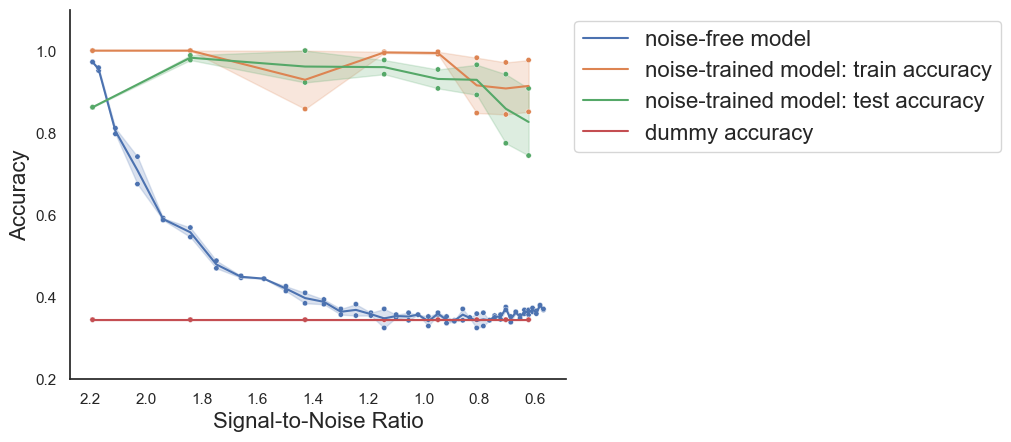

In [149]:
lineplot = sns.lineplot(concat_df, x= 'Signal-to-Noise Ratio', y = 'score', hue= 'train_or_test')
lineplot.legend_.set_title('')
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1), fontsize = variables.x_y_label_fontsize)
#convert to snr
concat_df = pd.merge(concat_df, std_snr_map,how = 'left')


scatterplot = sns.scatterplot(concat_df, x= 'Signal-to-Noise Ratio', y = 'score', hue= 'train_or_test', legend = False,s = variables.scatterplot_size)
#Hide the right and upper spines (axes)
ax = plt.gca()
ax.invert_xaxis()
# Choose specific values for tick marks on the x-axis
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.ylim(0.2, 1.1)
plt.xlabel('Signal-to-Noise Ratio', fontsize = variables.x_y_label_fontsize)
plt.ylabel('Accuracy', fontsize = variables.x_y_label_fontsize)
plt.savefig(fp.figure_filepath + '/' + 'Standar_deviation_vs_accuracy_for_noise.png', bbox_inches = 'tight')
plt.show()

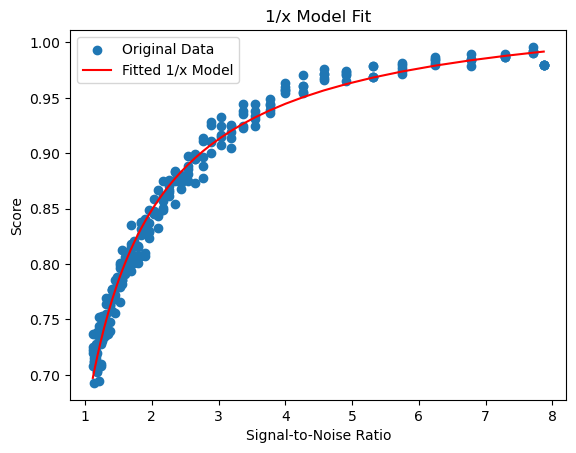

Fitted parameters: a = -0.3833804875782734, b = 1.0404665216510112
Uncertainties: a = 0.00321128607653541, b = 0.001742602235871816


In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the 1/x model function
def inverse_model(x, a, b):
    return a / x + b

# Your original code
curve_name = 'noise-trained model: test accuracy'
filt = (concat_df.loc[:, 'train_or_test'] == curve_name)
filt_concat_df = concat_df[filt]
data = filt_concat_df[['Signal-to-Noise Ratio', 'score']]

# Use curve_fit to fit the 1/x model to the data
x_data = filt_concat_df['Signal-to-Noise Ratio']
y_data = filt_concat_df['score']
params, covariance = curve_fit(inverse_model, x_data, y_data)

# Extract fitted parameters and uncertainties
a_fit, b_fit = params
a_uncertainty, b_uncertainty = np.sqrt(np.diag(covariance))

# Plot the original data and the fitted 1/x model
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, inverse_model(x_data, a_fit, b_fit), label='Fitted 1/x Model', color='red')
plt.legend()
plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Score')
plt.title('1/x Model Fit')
plt.show()

# Print fitted parameters and uncertainties
print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")
print(f"Uncertainties: a = {a_uncertainty}, b = {b_uncertainty}")


In [226]:
import numpy as np
from scipy.optimize import curve_fit

# Define the inverse model function
def inverse_model(x, a, b):
    return a / x + b

# Assuming you have the fitted parameters
params, _ = curve_fit(inverse_model, x_data, y_data)

# Extract fitted parameters
a_fit, b_fit = params

# Calculate the predicted (fitted) values
y_predicted = inverse_model(x_data, a_fit, b_fit)

# Calculate the total sum of squares (TSS)
tss = np.sum((y_data - np.mean(y_data))**2)

# Calculate the residual sum of squares (RSS)
rss = np.sum((y_data - y_predicted)**2)

# Calculate R-squared
r_squared = 1 - (rss / tss)

print(f"R-squared: {r_squared}")ac

R-squared: 0.982897565761529


In [269]:
concat_df.isnull().sum()

standard_deviation           0
observation_num              0
train_or_test                0
score                        0
Signal-to-Noise Ratio        0
log Signal-to-Noise Ratio    0
dtype: int64

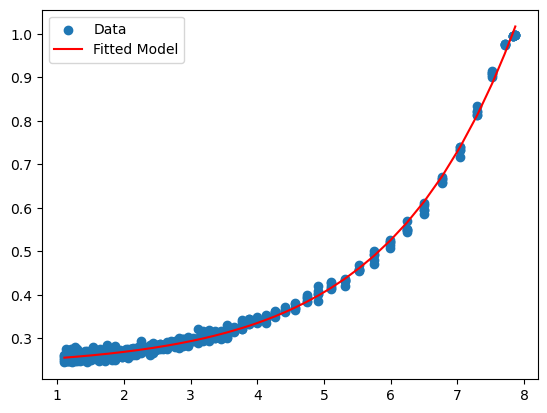

In [277]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exponential_model(x, a, b, c, d):
    return a * np.exp(b * (x - c)) + d

curve_name = 'noise-free model'
filt = (concat_df.loc[:, 'train_or_test'] == curve_name)
filt_concat_df = concat_df[filt]
data = filt_concat_df[['Signal-to-Noise Ratio', 'score']]

# Provide initial guesses for parameters a, b, c, and d
initial_guesses = [1, 0.1, 1, -1]

# Use curve_fit to fit the model to the data
x_data = filt_concat_df['Signal-to-Noise Ratio']
y_data = filt_concat_df['score']
params, covariance = curve_fit(exponential_model, x_data, y_data, p0=initial_guesses, maxfev=10000)

# Extract fitted parameters and uncertainties
a_fit, b_fit, c_fit, d_fit = params
a_uncertainty, b_uncertainty, c_uncertainty, d_uncertainty = np.sqrt(np.diag(covariance))

# Plot the data and the fitted model
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, exponential_model(x_data, a_fit, b_fit, c_fit, d_fit), label='Fitted Model', color='red')
plt.legend()
plt.show()

In [278]:
from sklearn.metrics import r2_score

# Calculate the predicted values using the fitted model
y_pred = exponential_model(x_data, a_fit, b_fit, c_fit, d_fit)

# Calculate R-squared value
r_squared = r2_score(y_data, y_pred)

print(f'R-squared value: {r_squared}')

R-squared value: 0.9972780080035155


In [246]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

curve_name = 'noise-free model'
filt = (concat_df.loc[:, 'train_or_test'] == curve_name)
filt_concat_df = concat_df[filt]
data = filt_concat_df[['Signal-to-Noise Ratio', 'score']]

# Provide initial guesses for parameters a, b, and c
initial_guesses = [1, -1, 1]

# Use curve_fit to fit the model to the data
x_data = filt_concat_df['Signal-to-Noise Ratio']
y_data = filt_concat_df['score']
params, covariance = curve_fit(quadratic_model, x_data, y_data, p0=initial_guesses, maxfev=1000)

# Extract fitted parameters and uncertainties
a_fit, b_fit, c_fit = params
a_uncertainty, b_uncertainty, c_uncertainty = np.sqrt(np.diag(covariance))

# Plot the data and the fitted model
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, quadratic_model(x_data, a_fit, b_fit, c_fit), label='Fitted Model', color='red')
plt.legend()
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

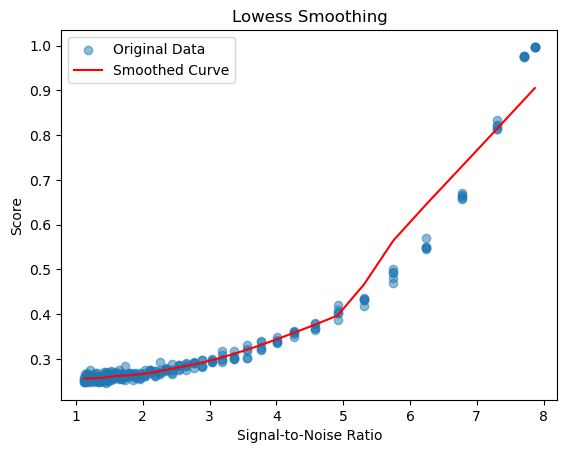

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Your original code
curve_name = 'noise-free model'
filt = (concat_df.loc[:, 'train_or_test'] == curve_name)
filt_concat_df = concat_df[filt]
data = filt_concat_df[['Signal-to-Noise Ratio', 'score']]

# Apply Lowess smoothing
smoothed = lowess(data['score'], data['Signal-to-Noise Ratio'], frac=0.3)

# Plot the original data and the smoothed curve
plt.scatter(data['Signal-to-Noise Ratio'], data['score'], label='Original Data', alpha=0.5)
plt.plot(smoothed[:, 0], smoothed[:, 1], label='Smoothed Curve', color='red')
plt.legend()
plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Score')
plt.title('Lowess Smoothing')
plt.show()

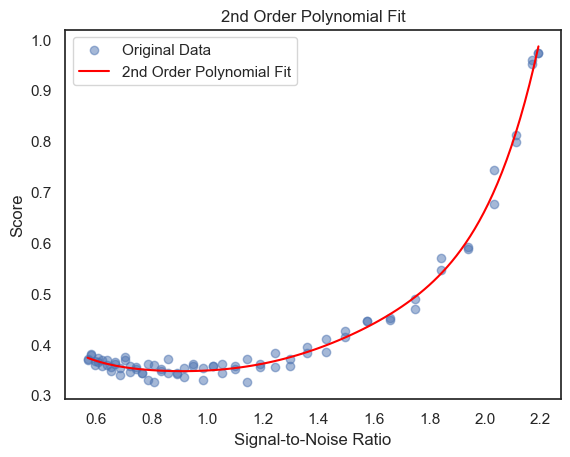

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Your original code
curve_name = 'noise-free model'
filt = (concat_df.loc[:, 'train_or_test'] == curve_name)
filt_concat_df = concat_df[filt]
data = filt_concat_df[['Signal-to-Noise Ratio', 'score']]

# Fit a 2nd order polynomial to the data
coefficients = np.polyfit(data['Signal-to-Noise Ratio'], data['score'], 6)
polynomial_fit = np.poly1d(coefficients)

# Generate x values for the fitted curve
x_fit = np.linspace(data['Signal-to-Noise Ratio'].min(), data['Signal-to-Noise Ratio'].max(), 100)

# Calculate y values using the polynomial fit
y_fit = polynomial_fit(x_fit)

# Plot the original data and the fitted polynomial
plt.scatter(data['Signal-to-Noise Ratio'], data['score'], label='Original Data', alpha=0.5)
plt.plot(x_fit, y_fit, label='2nd Order Polynomial Fit', color='red')
plt.legend()
plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Score')
plt.title('2nd Order Polynomial Fit')
plt.show()


### Resolution simulation

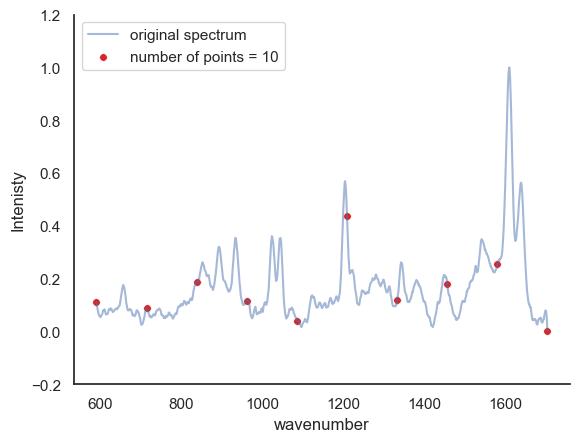

In [158]:
original_spectrum_df = mf.get_measurement_spectrum(0,melt_df)

# Create a figure and axis
fig, ax = plt.subplots()
sns.set(style="white")
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Initialize scatter plot with an empty plot
scatter = sns.scatterplot(ax=ax)

# Function to update the plot for each frame of the animation
def update(frame):
    # Clear previous plot
    ax.clear()
    # Update data for the plot (example: sinusoidal wave animation)
    num_datapoints_array = np.linspace(10, 300, frames)
    num_datapoints = int(num_datapoints_array[frame])
    sns.lineplot(data = original_spectrum_df, x ='wavenumber', y = 'intensity', label = 'original spectrum', alpha = 0.5)
    sns.scatterplot(data =get_equidistant_undersampling(mf.get_measurement_spectrum(0, melt_df), num_datapoints), x ='wavenumber', y = 'intensity', color = 'tab:red', s= 30,  label = 'number of points = ' + str(num_datapoints))
    plt.ylim(-0.2,1.2)
    ax.set_xlabel('wavenumber')
    ax.set_ylabel('Intenisty')
    return scatter

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)
ani.save(image_filepath + '/' + 'videos' + '/' +  'scatter_animation.mp4', writer='ffmpeg', fps=10)


In [169]:
answer = input('are you sure you want to run this code?')
if answer == 'y':
    num_observations = 5
    desired_num_datapoint_array = np.arange(20, 1000, 10)
    train_accuracy_array = []
    test_accuracy_array = []
    observation_nr_array = []
    current_num_datapoints_array = []
    num_datapoints_array = []
    start_time = time.time()
    
    for ii in range(len(desired_num_datapoint_array)): 
        # print(desired_num_points)
        desired_num_points = desired_num_datapoint_array[ii]
        print(str(int((ii+1)/len(desired_num_datapoint_array)*100)) + ' complete')
        for ii in range(num_observations): 
            train_accuracy, test_accuracy = get_accuracy_of_equidistant_undersampled_model(melt_df, desired_num_points)
            print(desired_num_points)
            print(test_accuracy)
            train_accuracy_array += [train_accuracy]
            test_accuracy_array += [test_accuracy]
            observation_nr_array += [ii]
            current_num_datapoints_array += [desired_num_points]
    
    end_time = time.time()
    seconds = end_time-start_time
    seconds_per_measurement = seconds/(len(desired_num_datapoint_array)*num_observations)
    
    sampling_step_results_df = pd.DataFrame({'num_datapoints': current_num_datapoints_array,
                                            'train_accuracy': train_accuracy_array,
                                             'test_accuracy': test_accuracy_array, 
                                            'observation_nr': observation_nr_array})
    sampling_step_results_df = pd.melt(sampling_step_results_df, id_vars=['num_datapoints', 'observation_nr'], value_vars = ['train_accuracy', 'test_accuracy'], var_name = 'train_or_test', value_name = 'score')
    # sampling_step_results_df = pd.melt(sampling_step_results_df, id_vars='num_datapoints', var_name='train_or_test', value_name='score')
    sampling_step_results_df.to_csv(fp.second_semester_simulation_data_path + '/' + 'score_vs_num_datapoints.csv', index = False)

are you sure you want to run this code? y


1 complete
20
0.9411764705882353
20
0.9705882352941176
20
0.9705882352941176
20
0.9338235294117647
20
0.9779411764705882
2 complete
30
0.9779411764705882
30
0.9926470588235294
30
0.9926470588235294
30
0.9852941176470589
30
0.9779411764705882
3 complete
40
0.9926470588235294
40
1.0
40
0.9926470588235294
40
0.9852941176470589
40
0.9926470588235294
4 complete
50
0.9926470588235294
50
0.9852941176470589
50
0.9779411764705882
50
0.9926470588235294
50
0.9705882352941176
5 complete
60
0.9926470588235294
60
0.9852941176470589
60
0.9852941176470589
60
0.9926470588235294
60
0.9852941176470589
6 complete
70
0.9852941176470589
70
0.9926470588235294
70
0.9926470588235294
70
0.9852941176470589
70
0.9779411764705882
7 complete
80
1.0
80
0.9926470588235294
80
0.9779411764705882
80
0.9926470588235294
80
0.9926470588235294
8 complete
90
0.9852941176470589
90
0.9852941176470589
90
0.9852941176470589
90
0.9926470588235294
90
0.9852941176470589
9 complete
100
1.0
100
0.9852941176470589
100
1.0
100
0.992647

In [206]:
sampling_step_results_df.replace({'train_accuracy': 'train', 'test_accuracy': 'test'})

,num_datapoints,observation_nr,train_or_test,score
0,20,0,train,0.961111
1,20,1,train,0.959259
2,20,2,train,0.961111
3,20,3,train,0.970370
4,20,4,train,0.953704
...,...,...,...,...
975,990,0,test,0.838235
976,990,1,test,0.897059
977,990,2,test,0.875000
978,990,3,test,0.830882


done


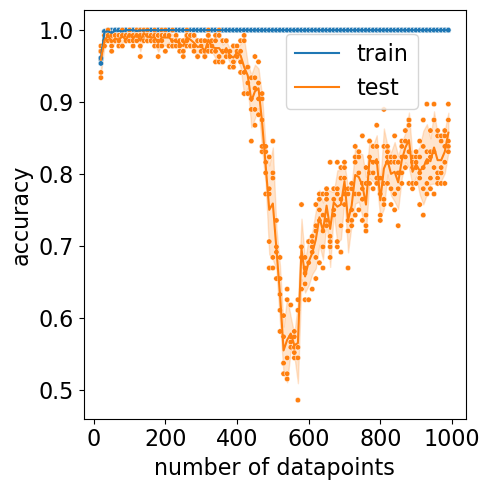

In [4]:
reload_libraries()
sampling_step_results_df = pd.read_csv(fp.second_semester_simulation_data_path + '/' + 'score_vs_num_datapoints.csv')
sampling_step_results_df = sampling_step_results_df.replace({'train_accuracy': 'train', 'test_accuracy': 'test'})
lineplot = sns.lineplot(data = sampling_step_results_df, x = 'num_datapoints', y = 'score', hue = 'train_or_test',  errorbar = 'sd')
lineplot.legend_.set_title('')
sns.scatterplot(data = sampling_step_results_df, x = 'num_datapoints', y = 'score', hue = 'train_or_test', s= variables.scatterplot_size, legend=False)
plt.xlabel('number of datapoints', fontsize = variables.x_y_label_fontsize)
plt.ylabel('accuracy',fontsize = variables.x_y_label_fontsize)
plt.legend(fontsize = variables.legend_fontsize, loc='center left', bbox_to_anchor=(0.5,0.85))
plt.xticks(fontsize = variables.tick_fontsize)
plt.yticks(fontsize = variables.tick_fontsize)
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.tight_layout()
plt.savefig(fp.figure_filepath + '/' + 'equidistant_undersampling_score.png', bbox_inches = 'tight', dpi = 1200, transparent = True)
plt.show()

#### Trying to understand this curve

In [5]:
def train_model_and_get_test_lda_df(vector_df, n_components):
    X, y = mf.get_X_y_from_vector_df(vector_df)
    # Splitting the data into training and testing sets with a 70-30 split ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    print(y_test.shape)
    #make the pipeline
    lda_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('lda', LinearDiscriminantAnalysis())
    ])
    
    #GMM pipeline
    gmm_pipeline = Pipeline([
        ('gmm', GaussianMixture(n_components=n_components))  # Adjust n_components for GMM
    ])
    
    #make the train_lda_df
    train_lda_df = pd.DataFrame(lda_pipeline.fit_transform(X_train, y_train))
    #predict the train labels
    train_predictions = gmm_pipeline.fit_predict(train_lda_df)
    #make the test_lda_df
    test_lda_df = pd.DataFrame(lda_pipeline.transform(X_test))
    #make the test predictions
    test_predictions = gmm_pipeline.predict(test_lda_df)
    
    # # Create a DataFrame to associate original labels with cluster assignments
    # train_df = pd.DataFrame({'true_class': y_train, 'gmm_predicted_class': train_predictions})
    # #create the test df
    # test_df = pd.DataFrame({'true_class': y_test, 'gmm_predicted_class': test_predictions})

    # #get the map based on majority voting
    # map = train_df.groupby('true_class').apply(mf.majority_vote).reset_index().rename({
    #     'true_class': 'gmm_class',
    #     0: 'gmm_class_numerical'}, axis = 1)
    
    # #now apply this majority map
    # class_train_df = mf.convert_GMM_to_class_labels(train_df, map)
    # class_test_df = mf.convert_GMM_to_class_labels(test_df, map)
    test_lda_df.loc[:, 'Class'] = np.array(y_test)
    return test_lda_df

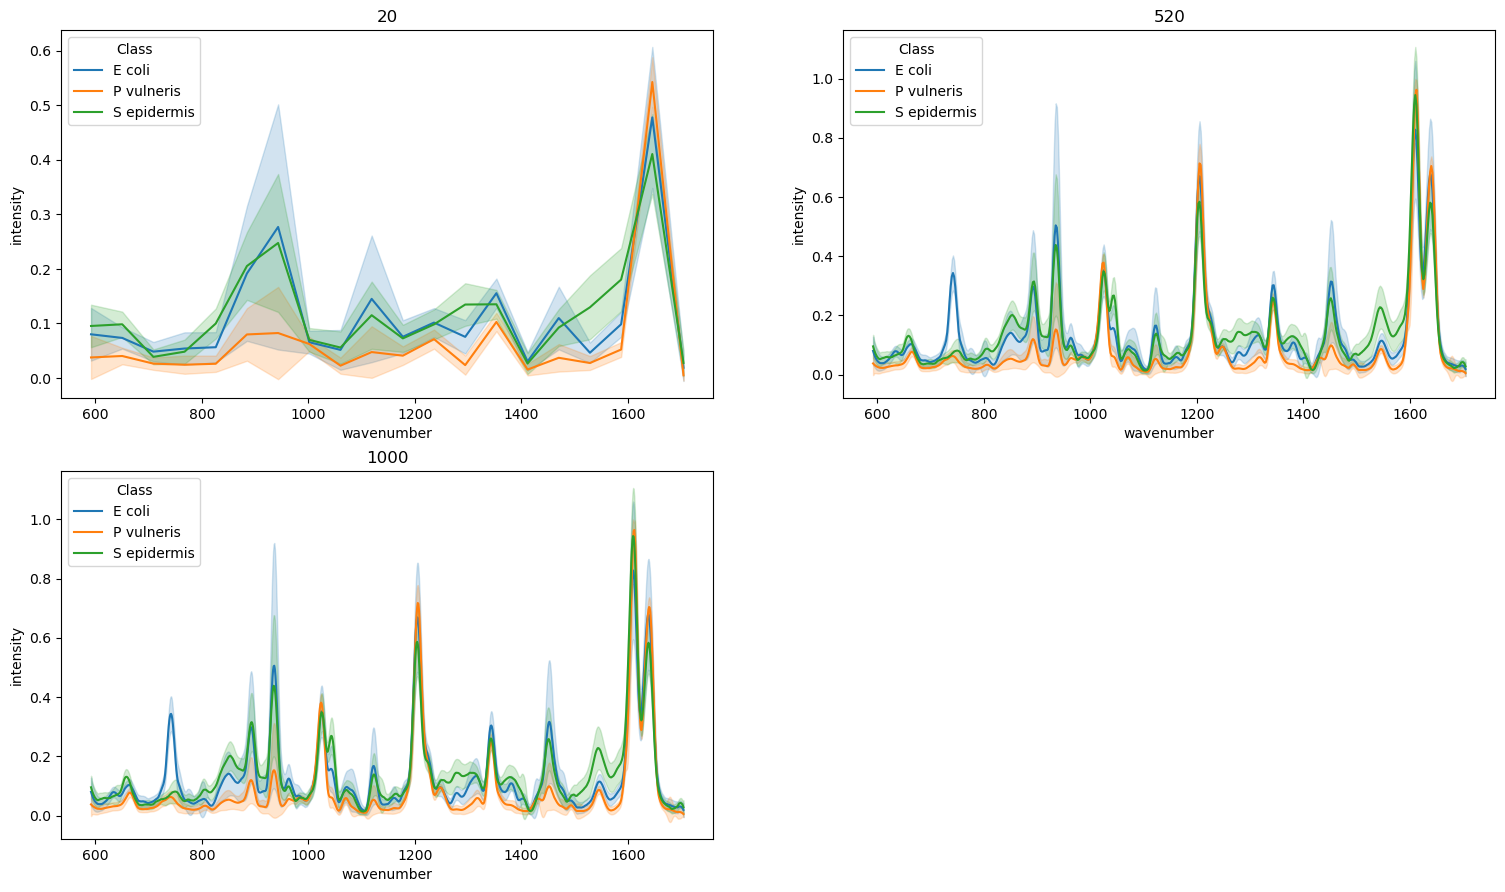

(136,)


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


(136,)


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


(136,)


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


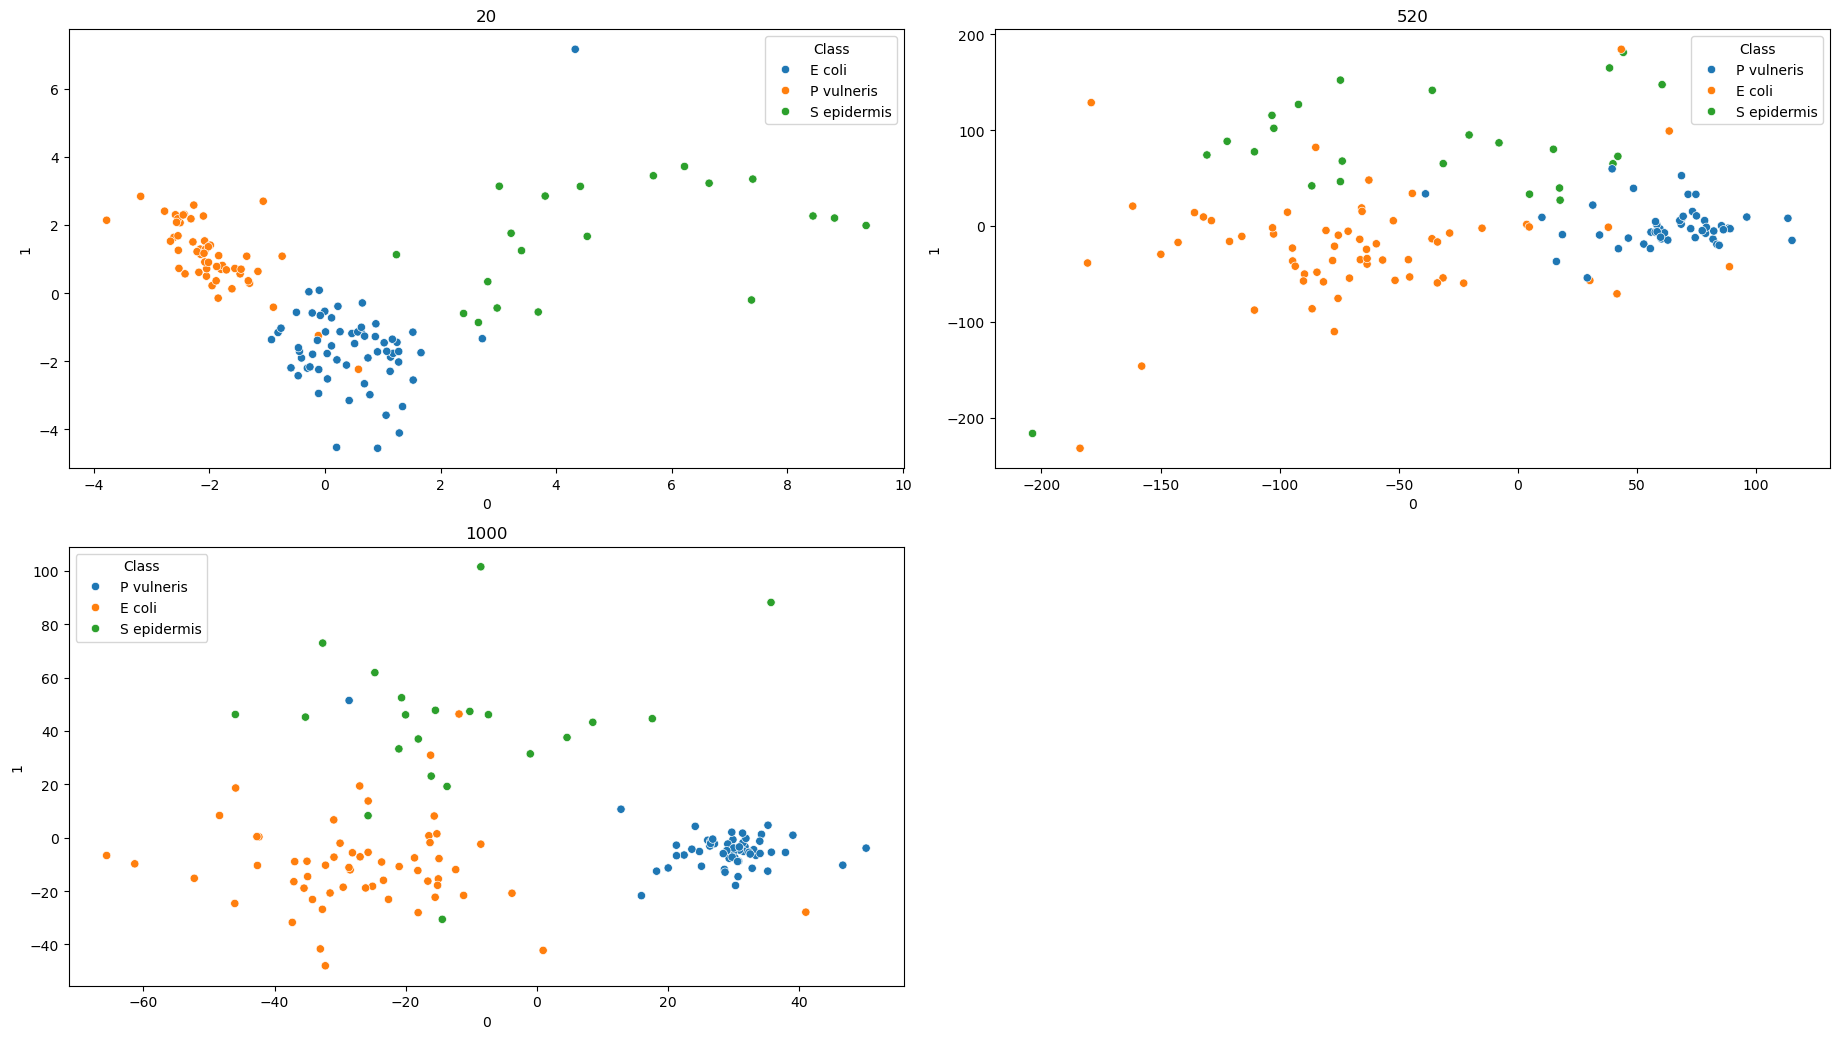

In [7]:
#lets take three points and plot the LDA etc
x1 = 20
x2 = 520
x3 = 1000
x1_undersampled_df = get_equidistant_undersampling(melt_df, x1)
x2_undersampled_df = get_equidistant_undersampling(melt_df, x2)
x3_undersampled_df = get_equidistant_undersampling(melt_df, x3)
x1_undersampled_vector_df = mf.get_vector_df(x1_undersampled_df, 'intensity')
x2_undersampled_vector_df = mf.get_vector_df(x2_undersampled_df, 'intensity')
x3_undersampled_vector_df = mf.get_vector_df(x3_undersampled_df, 'intensity')

plt.subplot(2,2,1)
plt.title(x1)
sns.lineplot(x1_undersampled_df, x= 'wavenumber', y = 'intensity', hue = 'Class', errorbar='sd')
plt.subplot(2,2,2)
sns.lineplot(x2_undersampled_df, x= 'wavenumber', y = 'intensity', hue = 'Class', errorbar='sd')
plt.title(x2)
plt.subplot(2,2,3)
sns.lineplot(x3_undersampled_df, x= 'wavenumber', y = 'intensity', hue = 'Class', errorbar='sd')
plt.title(x3)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

#show the lda
x1_lda_df = train_model_and_get_test_lda_df(x1_undersampled_vector_df, 3)
x2_lda_df = train_model_and_get_test_lda_df(x2_undersampled_vector_df, 3)
x3_lda_df = train_model_and_get_test_lda_df(x3_undersampled_vector_df, 3)

plt.subplot(2,2,1)
plt.title(x1)
sns.scatterplot(data = x1_lda_df, x = 0, y = 1, hue = 'Class')
plt.subplot(2,2,2)
plt.title(x2)
sns.scatterplot(data = x2_lda_df, x = 0, y = 1, hue = 'Class')
plt.subplot(2,2,3)
plt.title(x3)
sns.scatterplot(data = x3_lda_df, x = 0, y = 1, hue = 'Class')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.tight_layout()

In [141]:
class_train, class_test = train_model_and_get_results(x1_undersampled_vector_df, n_components=3)
class_test
mf.get_accuracy_and_f1(class_test.true_gmm_class, class_test.gmm_predicted_class)

(0.9852941176470589, 0.9819182101595452)

### Spectrum importance

In [217]:
num_datapoints = mf.get_measurement_spectrum(0, melt_df).shape[0]

num_averaging_measurements = 2
stride = 10  # Stride the step that you take to the right
jump = 20 # the step upwards

window_length_array = np.arange(10, 350, jump)

test_accuracy_array = []
center_wavenumber_array = []
current_window_length_array = []
current_averaging_meas_array = []

answer = input('are you sure you want to run this code? This might take a while')
if answer == 'y': 
    filename = input('what is the filename?')
    filename = filename + '_stride_' + str(stride) + '_jump_' + str(jump)
    print(filename)
    #change the size of the window
    for window_length in window_length_array: 
        windows = [(i, i + window_length - 1) for i in range(0, num_datapoints - window_length + 2, stride)]
        print(window_length)
        #shift the windows over the spectrum
        for window_number in range(len(windows)):
            begin_index = windows[window_number][0]
            end_index = windows[window_number][1]
            window_column_indices = list(np.array((range(begin_index, end_index)))+2)
            #get the vector of the spectrum
            window_vector_df =  vector_df.iloc[:, [0,1] + window_column_indices]
            #calculate the center wavenumber for plotting later
            center_wavelenth = int(np.array(window_vector_df.columns[[2, -1]]).astype('float').mean())
            #average all the measurements
            for current_measurement in range(num_averaging_measurements): 
                class_train_df, class_test_df = train_model_and_get_results(window_vector_df, n_components=3)
                #get the train and test accuracy
                train_accuracy, f1 = mf.get_accuracy_and_f1(class_train_df.loc[:, 'true_gmm_class'], class_train_df.loc[:, 'gmm_predicted_class'])
                test_accuracy, f1 = mf.get_accuracy_and_f1(class_test_df.loc[:, 'true_gmm_class'], class_test_df.loc[:, 'gmm_predicted_class'])
                #logging
                center_wavenumber_array += [center_wavelenth]
                test_accuracy_array += [test_accuracy]
                current_window_length_array += [window_length]
                current_averaging_meas_array += [current_measurement]

    #save everything into the dataframe
    results_df = pd.DataFrame({'window_length': current_window_length_array,
            'center_wavenumber': center_wavenumber_array,
            'averaging_meas_num': current_averaging_meas_array,
             'test_accuracy': test_accuracy_array})
    results_df.to_csv(fp.second_semester_simulation_data_path + '/' + filename + '.csv', index = False)
    

are you sure you want to run this code? This might take a while y
what is the filename? letstry_stride_10_jump_20_extended


letstry_stride_10_jump_20_extended_stride_10_jump_20
10
30
50
70
90
110
130
150
170
190
210
230
250
270
290
310
330


Interpretation of these results

In [211]:
#import the dataframe
results_df = pd.read_csv(fp.second_semester_simulation_data_path + '/' +'letstry_stride_10_jump_20' + '.csv')
averaged_results_df = results_df.groupby(['window_length', 'center_wavenumber'], as_index = False)['test_accuracy'].mean()
averaged_results_df

,window_length,center_wavenumber,test_accuracy
0,20,602,0.755556
1,20,615,0.681245
2,20,627,0.747126
3,20,639,0.712644
4,20,651,0.746086
...,...,...,...
1213,280,1517,0.793103
1214,280,1527,0.850575
1215,280,1537,0.804598
1216,280,1548,0.793103


In [212]:
# Define the window length for filtering the DataFrame
window_length = 30

window_length_array = list(results_df.loc[:, 'window_length'].unique())
interpolated_df = []
for window_length in window_length_array: 
    interpolated_df += [get_interpolated_df(averaged_results_df, window_length)]

heatmap_df = pd.concat(interpolated_df).pivot_table(index = 'window_length', columns = 'center_wavenumber', values = 'test_accuracy')
#put the lowest window length at the bottom of the plot
#heatmap_df = heatmap_df.sort_values('window_length', ascending = False)

done


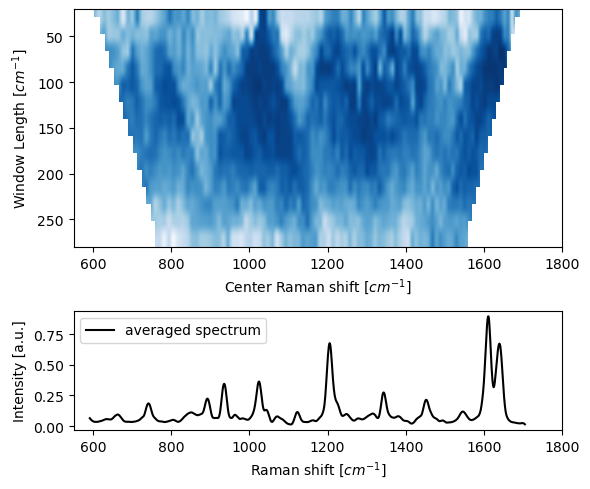

In [216]:
reload_libraries()
min_wavenumber = 550
max_wavenumber = 1800


# Create a figure with subplots and adjust the height ratios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1]})

# Plot intensity plot (imshow) on the first subplot (top)
x_labels = heatmap_df.columns
y_labels = heatmap_df.index
extent = [x_labels.min(), x_labels.max(), y_labels.max(), y_labels.min()]
img = ax1.imshow(heatmap_df, aspect='auto', cmap='Blues', extent=extent)
# Add contour lines to the intensity plot
extent = [x_labels.min(), x_labels.max(), y_labels.min(), y_labels.max()]
contour_levels = []  # Define contour levels as needed
gaussian_filtered_heatmap_df = gaussian_filter(heatmap_df, sigma =2)
contour = ax1.contour(gaussian_filtered_heatmap_df,levels=contour_levels, colors='black', extent = extent)  # Adjust colors and levels as needed
# Label contour lines
contour_labels = plt.clabel(contour, inline=True, fmt='%1.2f', fontsize=10, colors = 'black')
ax1.set_xlabel(fln.window_plot_x)
ax1.set_ylabel(fln.window_plot_y)
# ax1.colorbar(img)  # You can add a color bar if needed
ax1.set_xlim(min_wavenumber, max_wavenumber)

# Plot lineplot on the second subplot (bottom)
mean_spectrum = mf.get_mean_spectrum(melt_df)
sns.lineplot(data=mean_spectrum, x='wavenumber', y='intensity', ax=ax2, color = 'black', label = 'averaged spectrum')
ax2.set_xlim(min_wavenumber, max_wavenumber)
ax2.set_xlabel(fln.spectrum_x)
ax2.set_ylabel(fln.spectrum_y)

# ax2.axhline(y = 2, xmin = 0.3, xmax=0.7)

plt.tight_layout()
plt.savefig(fp.figure_filepath + '/' + 'model_performance_window_length.png', bbox_inches = 'tight', transparent = True, dpi = 1200)
plt.show()